In [1]:
from mm_ab import *

/home/charubaiel/.local/lib/python3.8/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
from sklearn.linear_model import LogisticRegression,LinearRegression
from lightgbm import LGBMRegressor
from tqdm.notebook import tqdm

In [3]:
base = pd.read_pickle('../data/expN34.pkl')

Линейные модели в сущности можно использовать для поиска влияния нашего АБ теста на данные  
Базово строя линейную модель Y=kX + b  
* где Y это наша метрика  
* а X это наша бинарная принадлежность к группе в АБ  

При выстраивании модели, коэффициент k при ней, будет обозначать вклад АБ теста в метрику  
Т.к. b будет равно общему эффекту на контроле

In [70]:
# генерируем данные
synth_control = sps.expon(200,100).rvs(1000) + sps.norm(0,100).rvs(1000)
synth_threatment = sps.expon(210,100).rvs(1000) + sps.norm(0,100).rvs(1000)

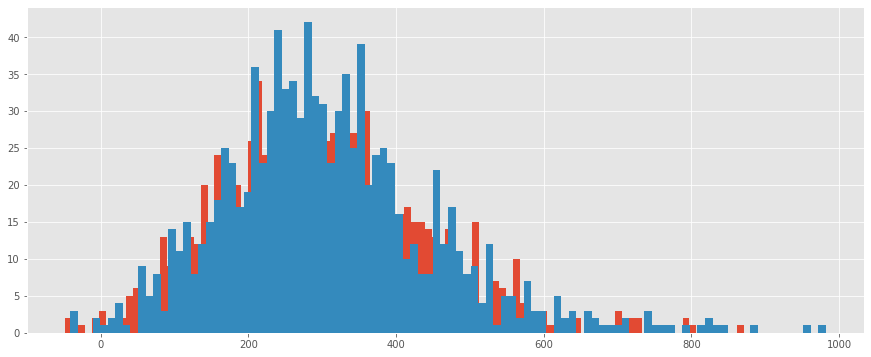

In [71]:
plt.hist(synth_control,bins=100);
plt.hist(synth_threatment,bins=100);

In [72]:
synth_data = pd.DataFrame({'values':np.concatenate([synth_control,synth_threatment]),
            'is_ab':np.concatenate([np.zeros(1000),np.ones(1000)])
            })

In [73]:
# оформим все проверки в одну функцию
def ols_vs_ttest(df,Y,T):
    X = df.drop([Y],axis=1) # наши фичи\ковариаты
    ttest_params = df.groupby(T)[Y].agg(['mean','std','count']) # статистика для ТТ

    ttest_result = {'pvalue':sps.ttest_ind_from_stats(*ttest_params.values.ravel()).pvalue,
                    'uplift':ttest_params['mean'][1] - ttest_params['mean'][0]}

    simple_lr = sm.OLS(df[Y],X.assign(const = 1),hasconst=False).fit()
    print(simple_lr.summary())
    ols_result =  {'uplift':simple_lr.params[0],
                'pvalue':simple_lr.pvalues[0]}

    return pd.DataFrame({'ttest':ttest_result,'ols':ols_result})


In [74]:
ols_vs_ttest(synth_data,'values','is_ab')

                                 OLS Regression Results                                
Dep. Variable:                 values   R-squared (uncentered):                   0.822
Model:                            OLS   Adj. R-squared (uncentered):              0.822
Method:                 Least Squares   F-statistic:                              4618.
Date:                Tue, 02 Aug 2022   Prob (F-statistic):                        0.00
Time:                        10:07:39   Log-Likelihood:                         -12742.
No. Observations:                2000   AIC:                                  2.549e+04
Df Residuals:                    1998   BIC:                                  2.550e+04
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

,ttest,ols
pvalue,0.203305,0.203305
uplift,8.056843,8.056843


In [75]:
# А раз они одинаковые, то мы можем использовать остальные ковариаты модели, как дополнительные параметры уточнения модели и вычленения эффекта других составляющих теста

# ML
<img src = 'https://miro.medium.com/max/500/1*qHbAsMNmdWQJkzm2SUA-8w.jpeg'>

In [9]:
simple_ml_test = base.groupby(['user','part','ab'])[['view','click']].sum().unstack([1,2])

In [10]:
simple_ml_test_ctr = simple_ml_test['click'] / simple_ml_test['view']

In [11]:
ml_df = pd.concat([simple_ml_test_ctr.swaplevel(0,1,axis=1)[0].dropna(subset=['AB']),simple_ml_test_ctr.swaplevel(0,1,axis=1)[1].dropna(subset=['AB'])])

In [12]:
ml_df

part,AB,AA
user,,
100006266691692773,0.000000,NaN
10001410055580393899,1.000000,0.666667
10001431488711581290,0.000000,0.000000
10001507526515839900,1.000000,0.000000
10002102718106860426,0.000000,NaN
...,...,...
9997567888084323655,0.000000,NaN
9997590035650076826,0.000000,0.000000
9997757924600272000,0.333333,0.333333


In [13]:
mldf = pd.get_dummies(base.set_index(['user','part']).drop(['click','view'],axis=1)).join(ml_df.stack().rename('target')).swaplevel(0,1).fillna(0)

In [97]:
def IPV(df, T, Y,is_raw_ps=False):
    X = df.drop([T,Y],axis=1).columns
    # estimate the propensity score
    ps = LogisticRegression(penalty='none').fit(df[X], df[T]).predict_proba(df[X])[:, 1]
    
    weight = (df[T]-ps) / (ps*(1-ps)) # define the weights
    if is_raw_ps:
        return ps
    return weight * df[Y] # compute the ATE

In [15]:
cuped_df = mldf.loc['AB'].join(mldf.loc['AA']['target'].rename('preexp_target')).loc[:,['ab','target','preexp_target']].dropna()

In [16]:
ps = IPV(mldf.loc['AB'].loc[cuped_df.index],T='ab',Y='target',is_raw_ps=True)

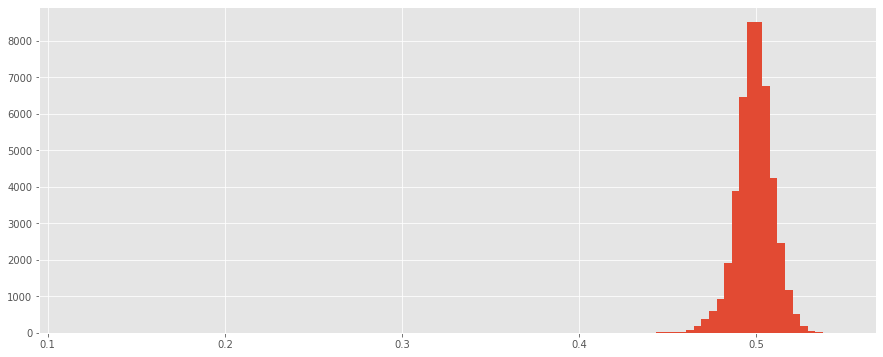

In [17]:
plt.hist(ps,bins=100);

In [18]:
class ABML(BaseABMethod):

    def prepare_data(self,cov_dict=None):
        self.calc_metric()
        if cov_dict is None:
            cov_dict = {'control':np.array([]),
                        'threatment':np.array([])}
                        
        control_data = np.vstack([  
                                    np.zeros(self.control_views.shape[0]),
                                    *cov_dict['control'].T,
                                    np.ones(self.control_views.shape[0]),
                                    self.control_ctr])
        
        threatment_data = np.vstack([
                                    np.ones(self.threatment_views.shape[0]),
                                    *cov_dict['threatment'].T,
                                    np.ones(self.threatment_views.shape[0]),
                                    self.threatment_ctr])

        data = np.hstack([control_data,threatment_data]).T
        
        target = data[:,-1]
        data = data[:,:-1]

        return data,target


    def ci_check(self,raw=False,**kwargs):
        data,target = self.prepare_data(**kwargs)
        model = sm.OLS(target,data).fit()

        if raw:
            return model.summary()

        return {'ttest': model.pvalues[0],
                'mwtest': None,
                'uplift': model.params[0],
                'relative_uplift':model.params[0] / self.control_ctr.mean(),
                'ci_left': model.conf_int()[0][0],
                'ci_right': model.conf_int()[0][1],
                'ci_lenght': model.conf_int()[0][1] - model.conf_int()[0][0],
                }
                    
    

In [19]:
super_ml = sm.OLS(cuped_df['target'],cuped_df.drop(['target'],axis=1).assign(const=1,ps=ps)).fit()
ps_ml = sm.OLS(cuped_df['target'],cuped_df.drop(['target','preexp_target'],axis=1).assign(const=1,ps=ps)).fit()
cuped_ml = sm.OLS(cuped_df['target'],cuped_df.drop(['target'],axis=1).assign(const=1)).fit()
base_ml = sm.OLS(cuped_df['target'],cuped_df.drop(['target','preexp_target'],axis=1).assign(const=1)).fit()

In [20]:
# conf interval ML
# По сути линейная регрессия == обычному тесту стьюдента
base_ml.conf_int().apply(lambda x: x[1] - x[0],axis=1)['ab']

0.00890813999719235

In [21]:
# conf interval ps
# еее , снизили на 15%
ps_ml.conf_int().apply(lambda x: x[1] - x[0],axis=1)['ab']

0.008723564843698841

In [22]:
# conf interval cuped
# еее , снизили на 15%
cuped_ml.conf_int().apply(lambda x: x[1] - x[0],axis=1)['ab']

0.007728638242669292

In [23]:
# conf interval super
# еее , снизили на 15%
super_ml.conf_int().apply(lambda x: x[1] - x[0],axis=1)['ab']

0.007637541132871562

In [24]:
print(base_ml.summary())

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     2.348
Date:                Mon, 01 Aug 2022   Prob (F-statistic):              0.125
Time:                        16:30:24   Log-Likelihood:                -829.74
No. Observations:               46984   AIC:                             1663.
Df Residuals:                   46982   BIC:                             1681.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
ab             0.0035      0.002      1.532      0.1

In [25]:
print(cuped_ml.summary())

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.247
Model:                            OLS   Adj. R-squared:                  0.247
Method:                 Least Squares   F-statistic:                     7720.
Date:                Mon, 01 Aug 2022   Prob (F-statistic):               0.00
Time:                        16:30:24   Log-Likelihood:                 5844.6
No. Observations:               46984   AIC:                        -1.168e+04
Df Residuals:                   46981   BIC:                        -1.166e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
ab                0.0023      0.002      1.153

In [26]:
print(ps_ml.summary())

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     1018.
Date:                Mon, 01 Aug 2022   Prob (F-statistic):               0.00
Time:                        16:30:24   Log-Likelihood:                 165.28
No. Observations:               46984   AIC:                            -324.6
Df Residuals:                   46981   BIC:                            -298.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
ab             0.0013      0.002      0.599      0.5

In [27]:
print(super_ml.summary())

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.265
Model:                            OLS   Adj. R-squared:                  0.265
Method:                 Least Squares   F-statistic:                     5656.
Date:                Mon, 01 Aug 2022   Prob (F-statistic):               0.00
Time:                        16:30:24   Log-Likelihood:                 6412.5
No. Observations:               46984   AIC:                        -1.282e+04
Df Residuals:                   46980   BIC:                        -1.278e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
ab                0.0009      0.002      0.457

# Uplift
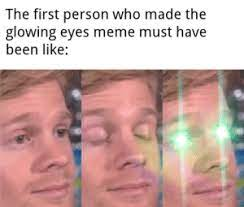

In [28]:
uplift_data = base.groupby(['user','part']).sum().reset_index(1).rename(columns={'part':'is_ab_test'})
uplift_data['is_ab_test'] = uplift_data['is_ab_test'] == 'AB'
uplift_data['target'] = uplift_data['click'] / uplift_data['view']
uplift_data.drop('click',axis=1,inplace=True)

In [29]:
uplift_aa = uplift_data.query('is_ab_test==0').drop('is_ab_test',axis=1)
uplift_ab = uplift_data.query('is_ab_test==1').drop('is_ab_test',axis=1)

In [30]:
def ci_check_meta_learners(meta_func,df,T,Y,**kwargs):
    ates = [meta_func(df.sample(frac=1, replace=True),T,Y,**kwargs).mean() for _ in tqdm(range(333))]

    model_stats = sps.norm(loc = np.mean(ates),scale=np.std(ates))

    return {'ttest': min(model_stats.cdf(0),model_stats.sf(0)),
            'mwtest': None,
            'uplift': model_stats.mean(),
            'relative_uplift':None,
            'ci_left': model_stats.ppf(0.025),
            'ci_right': model_stats.ppf(0.975),
            'ci_lenght': model_stats.ppf(0.975) - model_stats.ppf(0.025),
            }

In [31]:
def s_learner(df,Y,T,model=LGBMRegressor()):
    
    data = df.drop(Y,axis=1)
    target = df[Y]
    model.fit(data,target)

    return model.predict(data.assign(**{T:1})) - model.predict(data.assign(**{T:0}))


In [32]:
meta_learners_ci = {}

In [33]:
meta_learners_ci.update({'s_learner':ci_check_meta_learners(s_learner,uplift_ab,'target','ab')})

  0%|          | 0/333 [00:00<?, ?it/s]

In [34]:
meta_learners_result = {}

In [35]:
meta_learners_result['s_learner'] = {
                                    'AA':s_learner(uplift_aa,Y='target',T='ab',model=LGBMRegressor(n_estimators=1000)).mean(),
                                    'AB':s_learner(uplift_ab,Y='target',T='ab',model=LGBMRegressor(n_estimators=1000)).mean(),
                                        }

In [36]:
from copy import copy

In [37]:
def t_learner(df,Y,T,model=LGBMRegressor()):
    X0 = df.query(f'{T}==0').drop([Y,T],axis=1)
    Y0 = df.query(f'{T}==0')[Y]

    X1 = df.query(f'{T}==1').drop([Y,T],axis=1)
    Y1 = df.query(f'{T}==1')[Y]

    m0 = copy(model)
    m1 = copy(model)

    m0.fit(X0,Y0)
    m1.fit(X1,Y1)

    return m1.predict(df.drop([Y,T],axis=1)) - m0.predict(df.drop([Y,T],axis=1))


In [38]:
meta_learners_ci.update({'t_learner':ci_check_meta_learners(t_learner,uplift_ab,'target','ab')})

  0%|          | 0/333 [00:00<?, ?it/s]

In [39]:
meta_learners_result['t_learner'] = {
                                    'AA':t_learner(uplift_aa,Y='target',T='ab',model=LGBMRegressor(n_estimators=1000)).mean(),
                                    'AB':t_learner(uplift_ab,Y='target',T='ab',model=LGBMRegressor(n_estimators=1000)).mean(),
                                        }

In [40]:
from sklearn.model_selection import cross_val_predict

In [41]:
def dd_learner(df,Y,T,model=LGBMRegressor()):

    data = df.drop([Y,T],axis=1)
    target = df[Y]
    threatment = df[T]
    
    debaise = copy(model)
    denoise = copy(model)


    T_res = threatment - cross_val_predict(debaise,data,threatment,cv=5)
    Y_res = target - cross_val_predict(denoise,data,target,cv=5)

    W = T_res **2
    Y_star = Y_res / T_res

    final_model = copy(model)

    final_model.fit(data,Y_star,sample_weight=W)

    return final_model.predict(data).mean()


In [42]:
meta_learners_ci.update({'dd_learner':ci_check_meta_learners(dd_learner,uplift_ab,'target','ab')})

  0%|          | 0/333 [00:00<?, ?it/s]

In [43]:
# Для цисленных переменных влияния (сикдки , бонусы, баллы и тд)
meta_learners_result['dd_learner'] = {
                                    'AA':dd_learner(uplift_aa,Y='target',T='ab',model=LGBMRegressor(n_estimators=1000)).mean(),
                                    'AB':dd_learner(uplift_ab,Y='target',T='ab',model=LGBMRegressor(n_estimators=1000)).mean(),
                                        }

In [76]:
def dr_learner(df,Y,T):
    
    X = df.drop([T,Y],axis=1).columns

    ps = LogisticRegression(C=1e6, max_iter=1000).fit(df[X], df[T].astype(bool)).predict_proba(df[X])[:, 1]

    mu0 = LGBMRegressor().fit(df.query(f"{T}==0")[X], df.query(f"{T}==0")[Y]).predict(df[X])
    mu1 = LGBMRegressor().fit(df.query(f"{T}==1")[X], df.query(f"{T}==1")[Y]).predict(df[X])
    return (
        (df[T]*(df[Y] - mu1)/ps + mu1) -
        ((1-df[T])*(df[Y] - mu0)/(1-ps) + mu0)
    )

In [78]:
meta_learners_ci.update({'dr_learner':ci_check_meta_learners(dr_learner,uplift_ab,'target','ab')})

  0%|          | 0/333 [00:00<?, ?it/s]

In [79]:
pd.DataFrame(meta_learners_ci)

,s_learner,t_learner,dd_learner,dr_learner
ttest,0.229536,0.407425,0.369144,0.434526
mwtest,NaN,NaN,NaN,NaN
uplift,0.000479,0.000308,0.000412,0.000209
relative_uplift,NaN,NaN,NaN,NaN
ci_left,-0.000788,-0.002271,-0.002004,-0.002272
ci_right,0.001746,0.002887,0.002828,0.002689
ci_lenght,0.002534,0.005158,0.004832,0.004961


# IPV & Double robust
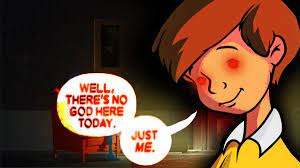

In [80]:
drdd_data = base.groupby(['user','part']).sum().reset_index(1).rename(columns={'part':'is_ab_test'})

In [81]:
drdd_data['is_ab_test'] = drdd_data['is_ab_test'] == 'AB'
drdd_data['target'] = drdd_data['click'] / drdd_data['view']
drdd_data.drop('click',axis=1,inplace=True)

## IPV

In [83]:
IPV(drdd_data.query('is_ab_test==True'),'ab','target')

0.00046526603623235727

In [95]:
ols_data = drdd_data.query('is_ab_test==True').astype(int)

In [101]:
ps_ols = sm.OLS(ols_data['target'].values,ols_data[['ab']].assign(const=1,ps=IPV(ols_data,'ab','target',is_raw_ps=True))).fit()
raw_ols = sm.OLS(ols_data['target'].values,ols_data.drop(['is_ab_test','target'],axis=1).assign(const=1)).fit()

ab
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: ps, dtype: object

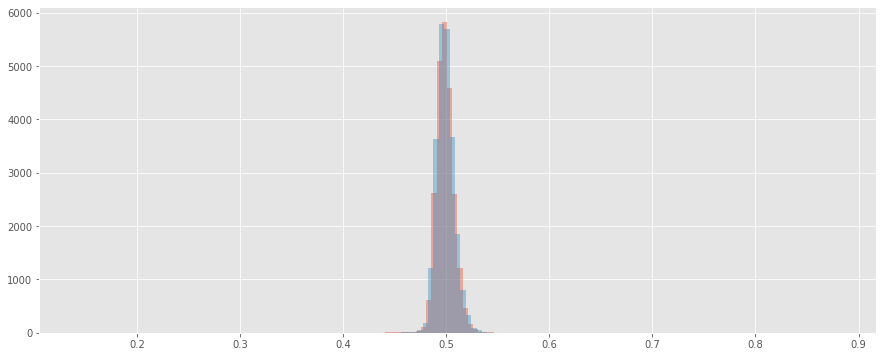

In [102]:
ols_data.assign(ps=IPV(ols_data,'ab','target',is_raw_ps=True)).groupby('ab')['ps'].hist(alpha=0.4,bins=100)

In [103]:
print(raw_ols.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     80.17
Date:                Tue, 02 Aug 2022   Prob (F-statistic):          3.95e-212
Time:                        10:16:26   Log-Likelihood:                 14469.
No. Observations:               46984   AIC:                        -2.891e+04
Df Residuals:                   46970   BIC:                        -2.879e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
ab                         0

In [104]:
print(ps_ols.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     14.08
Date:                Tue, 02 Aug 2022   Prob (F-statistic):           7.68e-07
Time:                        10:16:27   Log-Likelihood:                 13968.
No. Observations:               46984   AIC:                        -2.793e+04
Df Residuals:                   46981   BIC:                        -2.790e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
ab             0.0004      0.002      0.220      0.8

## DID

In [89]:
idx = drdd_data.groupby(level=0)['is_ab_test'].nunique().where(lambda x: x==2).dropna().index
drdd_data = drdd_data.loc[idx]

In [90]:
def DRDID ( df,X,W,T,Y):

    ps = LogisticRegression(penalty='none').fit(df.query(f'{W}==0')[X],df.query(f'{W}==0')[T]).predict_proba(df.query(f'{W}==0')[X])[:,1]
    wp_tr = df.query(f'{W}==0')[T] / df.query(f'{W}==0')[T].mean()
    wp_count = ps * (1 - df.query(f'{W}==0')[T]) / (1 - ps)
    wp_pr = wp_count / wp_count.mean()
    ipv = wp_tr - wp_pr

    mu_0_p = LinearRegression().fit(df.query(f'{T}==0 & {W}==1')[X], df.query(f'{T}==0 & {W}==0')[Y]).predict(df.query(f'{W}==1')[X])

    mu_1_p = LinearRegression().fit(df.query(f'{T}==0 & {W}==1')[X], df.query(f'{T}==0 & {W}==1')[Y]).predict(df.query(f'{W}==1')[X])



    mu_delta = mu_1_p - mu_0_p

    Y_delta = df.query(f'{W}==1')[Y] - df.query(f' {W}==0')[Y]


    ATT = np.mean(ipv * (Y_delta - mu_delta))

    return ATT

In [91]:
did_result = DRDID(drdd_data, X=drdd_data.filter(regex='cov').columns,W='is_ab_test',T='ab',Y='target')

In [105]:
did_result

0.0007777269685631949

In [10]:
data_aa = base.query('part == "AA"').drop(['part','cov_device'],axis=1).iloc[:,:-2]
target_aa = base.query('part == "AA"')['click'] / base.query('part == "AA"')['view']

In [51]:
data_ab = base.query('part == "AB"').drop(['part','cov_device'],axis=1).iloc[:,:-2]
target_ab = base.query('part == "AB"')['click'] / base.query('part == "AB"')['view']

In [15]:
from sklearn import linear_model
from sklearn import model_selection
from sklearn import metrics 

In [63]:
target_aa.loc[[2,2]]

2    0.0
2    0.0
dtype: float64

In [71]:
from collections import defaultdict

In [76]:
result = defaultdict(list)

for _ in tqdm(range(1000)):
    idx = np.random.choice(data_aa.index,size=data_aa.shape[0],replace=True)
    model = linear_model.BayesianRidge(n_iter=1000)
    model.fit(data_aa.loc[idx],target_aa.loc[idx])

    y_hat = model.predict(data_ab)

    result['mse'].append(metrics.mean_squared_error(y_hat,target_ab))
    result['diff'].append((y_hat - target_ab).mean())

  0%|          | 0/1000 [00:00<?, ?it/s]

<AxesSubplot:>

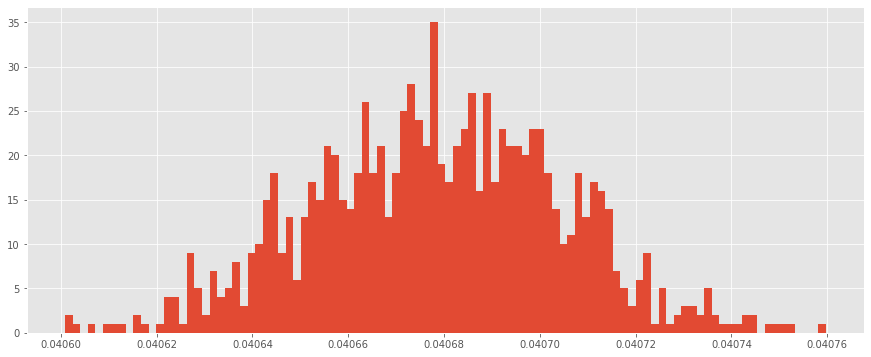

In [81]:
pd.DataFrame(result)['mse'].hist(bins=100)

<AxesSubplot:>

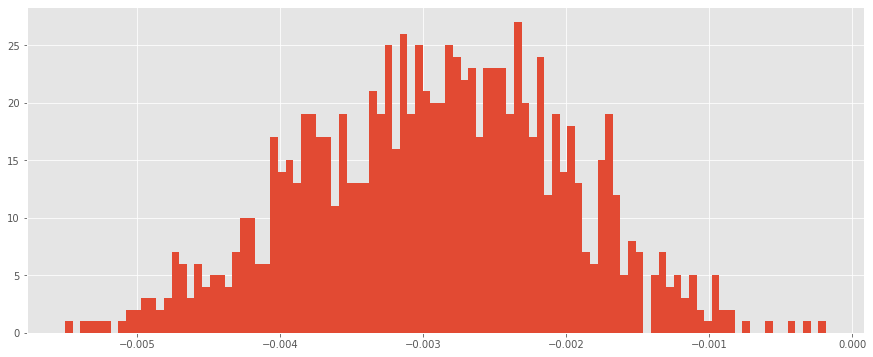

In [82]:
pd.DataFrame(result)['diff'].hist(bins=100)